In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

### Loading the dataset

In [2]:
DATASET_PATH_HS = '../datasets/hydroshoot_impulse_v2.csv'
DATASET_PATH_CN = '../datasets/dataset_NEMA3_impulse_v2.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset as DatasetHS
from rc_dataset_impulse_cnwheat import ExperimentDataset as DatasetCN

hs_dataset = DatasetHS(csv_path=DATASET_PATH_HS)
cn_dataset = DatasetCN(csv_path=DATASET_PATH_CN)

In [4]:
hs_dataset.get_run_ids()

array(['2012-08-01__width0__0', '2012-08-01__width1__0',
       '2012-08-01__width1__1500', '2012-08-01__width3__0',
       '2012-08-01__width3__1500', '2012-08-01__width5__0',
       '2012-08-01__width5__1500', '2012-08-01__width7__0',
       '2012-08-01__width7__1500', '2012-08-01__width9__0',
       '2012-08-01__width9__1500'], dtype=object)

In [5]:
cn_dataset.get_run_ids()


array(['NEMA_H3__day0__width0__0', 'NEMA_H3__day18__width1__0',
       'NEMA_H3__day18__width1__4000', 'NEMA_H3__day18__width3__0',
       'NEMA_H3__day18__width3__4000', 'NEMA_H3__day18__width5__0',
       'NEMA_H3__day18__width5__4000', 'NEMA_H3__day18__width7__0',
       'NEMA_H3__day18__width7__4000', 'NEMA_H3__day18__width9__0',
       'NEMA_H3__day18__width9__4000'], dtype=object)

### Figures

In [6]:
def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var(axis=0) + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = ((base_state - state)**2 / norm_factor).mean()
  return dist


def get_data(run1, run2, state, dataset, start, stop):
  # get raw data
  data1 = dataset.get_state(state, run1)[start:stop]
  data2 = dataset.get_state(state, run2)[start:stop]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

### Compact Figure

C:\Users\Max\AppData\Local\Temp/ipykernel_22568/553082876.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['12:00' if x == 444 else '' for x in xticks],  fontsize=14)


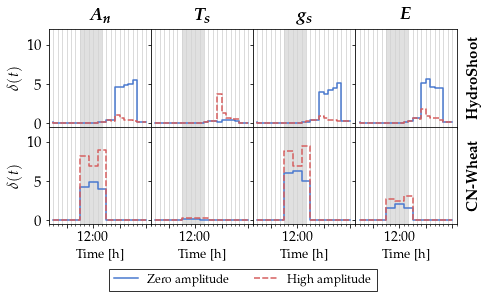

In [38]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

hs_reservoirs = [
  'state_An',
  'state_Tlc',
  'state_gs',
  'state_E', 
  'state_Flux',
  'state_psi_head',
]

cn_reservoirs = [
  'state__An',
  'state__Ts',
  'state__gs',
  'state__Transpiration', 
]

hs_symbols = {
  'state_An': r'$A_n$',
  'state_Tlc': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}
hs_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in hs_symbols.items()}


cn_symbols = {
  'state__An': r'$A_n$',
  'state__Ts': r'$T_s$',
  'state__gs': r'$g_s$',
  'state__Transpiration': r'$E$',
}
cn_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in cn_symbols.items()}

hs_baseline = '2012-08-01__width0__0'
hs_template = lambda width, value: f'2012-08-01__width{width}__{value}'

cn_baseline = 'NEMA_H3__day0__width0__0'
cn_template = lambda width, value: f'NEMA_H3__day18__width{width}__{value}'

WIDTH = 5
INTERVAL = (10, 15)  # width 5
P0, P1 = INTERVAL

HS_START = 24 * 4 + 6 - 3
HS_STOP = 24 * 6 - 18 - 3 - 2

CN_START = 18 * 24 + 6 - 3
CN_STOP = 19 * 24 - 2 + 5 - 2

LABELS = [r'Zero amplitude', r'High amplitude']


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 4, figsize=(7, 4), sharex=False, sharey=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  hs_axs, cn_axs = axs

  ### ROW 1: HYDROSHOOT ###
  try:
    for col, ax, res, in zip([0, 1, 2, 3], hs_axs, hs_reservoirs):
      # get data
      pulse_lo = get_data(hs_baseline, hs_template(WIDTH, 0), res, hs_dataset, HS_START, HS_STOP)
      pulse_hi = get_data(hs_baseline, hs_template(WIDTH, 1500), res, hs_dataset, HS_START, HS_STOP)
      df = pd.DataFrame(np.array([pulse_lo, pulse_hi]).T, columns=LABELS, index=np.arange(0, HS_STOP - HS_START))
      
      # plot data
      ax.set_ylim(-.5, 12)
      sns.lineplot(data=df, ax=ax, palette=plot_colors, drawstyle='steps-pre')
      ax.axvspan(4 * 24 + P0 - 1 - HS_START, 4 * 24 + P1 - 1 - HS_START, facecolor='0.2', alpha=0.15, label='Impulse duration')

      # labeling
      ax.get_legend().remove()
  except Exception as e:
    raise e

  ### ROW 2: CN-WHEAT ###
  try:
    for col, ax, res, in zip([0, 1, 2, 3], cn_axs, cn_reservoirs):
      # get data
      pulse_lo = get_data(cn_baseline, cn_template(WIDTH, 0), res, cn_dataset, CN_START, CN_STOP)
      pulse_hi = get_data(cn_baseline, cn_template(WIDTH, 4000), res, cn_dataset, CN_START, CN_STOP)
      df = pd.DataFrame(np.array([pulse_lo, pulse_hi]).T, columns=LABELS, index=np.arange(CN_START, CN_STOP))
      
      # plot data
      ax.set_ylim(-.5, 12)
      sns.lineplot(data=df, ax=ax, palette=plot_colors, drawstyle='steps-pre')
      ax.axvspan(18 * 24 + P0 - 1, 18 * 24 + P1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration')

      # labeling
      ax.get_legend().remove()
  except Exception as e:
    raise e

  for ax in axs.flatten():
    # Grids
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(axis='x', linestyle='solid', color='lightgrey', which='both')
    
  # Labeling
  for i_res, ax in enumerate(axs[0, :]):
    ax.annotate(hs_symbols[hs_reservoirs[i_res]], (0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=18)
  for name, ax in zip(['HydroShoot', 'CN-Wheat'], axs[:, -1]):
    ax.annotate(f'\\textbf{{{name}}}', (1.17, 0.5), xycoords='axes fraction', va='center', ha='center', rotation=90, fontsize=15)
  for ax in axs[:, 0]:
    ax.set_ylabel(r'$\delta(t)$')

  for ax in axs[1, :]:
    xticks = ax.get_xticks()
    ax.set_xticklabels(['12:00' if x == 444 else '' for x in xticks],  fontsize=14)
    ax.set_xlabel(r'Time [\unit{\hour}]', fontsize=13)

  fig.legend(LABELS, loc='lower center', fancybox=False, shadow=False, ncol=3, 
             frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.065), fontsize=12)
  
  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0)  
  plt.savefig('impulse_reservoirs_compact.png', dpi=200, facecolor='white', bbox_inches='tight')


### Details

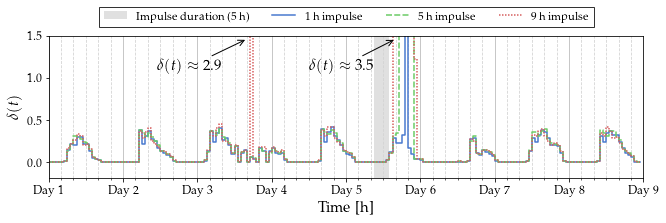

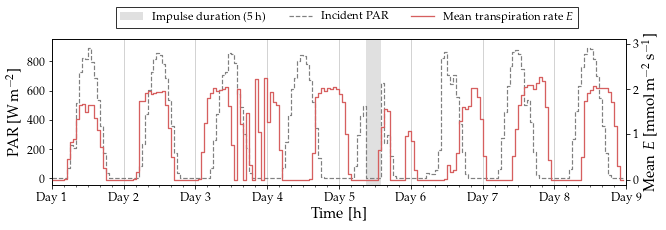

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FuncFormatter)

reservoir = 'state_E'
symbol_res = {'state_E': r'$\boldsymbol{E}$'}
pulse_width = 5
pulse_interval = (10, 15)
p0, p1 = pulse_interval

baseline = '2012-08-01__width0__0'
experiment1 = f'2012-08-01__width1__0'
experiment2 = f'2012-08-01__width5__0'
experiment3 = f'2012-08-01__width9__0'

START = 0 * 24
STOP = 8 * 24


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    if x % 24 == 0:
      labels.append(f'Day {x // 24 + 1}')
    elif x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, ax1 = plt.subplots(1, 1, figsize=(9.5, 3), sharex=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  ### TOP AX: RESERVOIR DIVERGENCE FOR ENTIRE EXPERIMENT ###
  try:
    # prep data
    # div_1 = get_data(baseline, experiment1, reservoir)
    # div_2 = get_data(experiment2, experiment1, reservoir)
    # div_3 = get_data(experiment3, experiment1, reservoir)

    div_1 = get_data(baseline, experiment1, reservoir)
    div_2 = get_data(baseline, experiment2, reservoir)
    div_3 = get_data(baseline, experiment3, reservoir)
    div = np.array([div_1, div_2, div_3])
    df = pd.DataFrame(div.T)
    df.columns = [
      # r'Control experiment vs. \SI{1}{\hour} impulse', 
      # r'Control experiment vs. \SI{5}{\hour} impulse', 
      # r'Control experiment vs. \SI{9}{\hour} impulse', 
      r'\SI{1}{\hour} impulse', 
      r'\SI{5}{\hour} impulse', 
      r'\SI{9}{\hour} impulse', 
    ]
    df.index = np.arange(START, STOP)

    # plot data
    ax1.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration (\SI{5}{\hour})')
    # ax1.axvspan(4 * 24 + 11 - 1, 4 * 24 + 14 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration (\\SI{3}{\hour})')
    sns.lineplot(data=df, ax=ax1, drawstyle='steps-pre')

    # Axes
    ax1.set_xlim(START, STOP)
    ax1.set_ylim(top=1.5)
    ax1.xaxis.set_minor_locator(MultipleLocator(4))
    ax1.xaxis.set_major_locator(MultipleLocator(24))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Day {x // 24 + 1:.0f}'))
    ax1.grid(axis='x', linestyle='solid', color='darkgrey', alpha=.65, linewidth=1, which='major')
    ax1.grid(axis='x', linestyle='dashed', color='lightgrey', which='minor')
    ax1.tick_params(axis='both', which='both', labelsize=12)
    
    # Labeling
    ax1.set_ylabel(r'$\delta(t)$')
    ax1.set_xlabel(r'Time [\unit{\hour}]')
    ax1.get_legend().remove()
    ax1.annotate(r"$\delta(t) \approx 2.9$", xy=(2 * 24 + 16, 1.47), 
                xytext=(2 * 24 + 8, 1.1), arrowprops=dict(arrowstyle="->"), ha='right')
    ax1.annotate(r"$\delta(t) \approx 3.5$", xy=(4 * 24 + p0 + 6, 1.47), 
                xytext=(4 * 24 + p0 + -1, 1.1), arrowprops=dict(arrowstyle="->"), ha='right')

    fig.legend(loc='upper center', fancybox=False, shadow=False, ncol=4, 
              frameon=True, edgecolor='black', bbox_to_anchor=(0.52, 1.07), fontsize=11.5)
    plt.tight_layout()
    plt.savefig('hydroshoot_instability_divergence.png', dpi=200, facecolor='white', bbox_inches='tight')
  except:
    pass

  ### BOTTOM AX: ACTUAL DATA ###
  try:
    fig, ax2 = plt.subplots(1, 1, figsize=(9.5, 3), sharex=True)
    colors = sns.color_palette()
    plot_colors = colors[0], colors[2]

    # prep data
    input_PAR = dataset.get_target('input_Rg', f'2012-08-01__width{pulse_width}__0')[START:STOP]
    res_series = dataset.get_state(reservoir, f'2012-08-01__width{pulse_width}__0')[START:STOP]
    np.random.seed(42)
    res_series = res_series.mean(axis=1)
    
    # plot_data
    time = np.arange(START, STOP)
    ax2.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration (\SI{5}{\hour})')
    ax2.plot(time, input_PAR, color='grey', marker='s', markersize=0, drawstyle='steps-pre',
            label='Incident PAR', linewidth=1.2, linestyle='dashed')
    res_ax = ax2.twinx()
    res_ax.plot(time, res_series * 1000, color=colors[2], linestyle='solid', marker='^', 
                markersize=0, drawstyle='steps-pre', label='Mean transpiration rate $E$', linewidth=1.3)

    # Axes
    ax2.set_xlim(START, STOP)
    ax2.set_ylim(top=950)
    res_ax.set_ylim(top=3.1)
    ax2.xaxis.set_minor_locator(MultipleLocator(4))
    ax2.xaxis.set_major_locator(MultipleLocator(24))
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Day {x // 24 + 1:.0f}'))
    ax2.grid(axis='x', linestyle='solid', color='lightgrey', alpha=1, linewidth=1, which='major')
    ax2.tick_params(axis='both', which='both', labelsize=12)
    res_ax.tick_params(axis='both', which='both', labelsize=12)

    # Labeling
    ax2.legend(loc='upper left').remove()
    res_ax.legend(loc='upper right').remove()
    ax2.set_ylabel(r'PAR [\unit{\watt\per\square\meter}]')
    res_ax.set_ylabel(r'Mean $E$ [\unit{\milli\mol\per\square\meter\per\second}]')
    ax2.set_xlabel(r'Time [\unit{\hour}]')

    fig.legend(loc='upper center', fancybox=False, shadow=False, ncol=3, 
              frameon=True, edgecolor='black', bbox_to_anchor=(0.52, 1.1), fontsize=11.5)
    plt.tight_layout()
    plt.savefig('hydroshoot_instability_behavior.png', dpi=200, facecolor='white', bbox_inches='tight')
  except:
    pass